In [1]:
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time
# import pylab as pl
# from IPython import display
from scipy.stats import multivariate_normal
import re
import random

# Helper Functions

In [2]:
def read_file(filename):
    with open(filename, "r") as f:
        data = f.read()[:-2]

    data = re.sub("^( )*","",data)
    data = re.sub("( )*\n( )*","\n",data)
    data = re.sub("( )+"," ",data)
    data_l = data.split("\n")
    for i in range(len(data_l)):
        data_l[i] = data_l[i].split(" ")
        data_l[i] = [ float(j) for j in data_l[i] ]
    data_l = np.array(data_l)
    return data_l

def one_hot(x, n):
    if type(x) == list:
        x = np.array(x)
    x = x.flatten()
    o_h = np.zeros((len(x), n))
    o_h[np.arange(len(x)), x] = 1
    return o_h

def draw_loss_graph(losses, filepath):
    plt.clf()
    x_points = [i for i in range(0,len(losses))]
    cost_line, = plt.plot(x_points, losses)
    plt.title("Avg SSE v/s Iteration")
    plt.savefig(filepath)
#     plt.show()

def draw_logloss_graph(losses, filepath):
    plt.clf()
    x_points = [i for i in range(0,len(losses))]
    cost_line, = plt.plot(x_points, losses)
    plt.title("Avg LogLoss v/s Iteration")
    plt.savefig(filepath)
#     plt.show()

# KMeans

In [3]:
def init_centers(data, K):
    low, high = np.min(data, axis=0), np.max(data, axis=0)
    centers = []
    for i in range(K):
        centers.append(np.random.uniform(low, high))
    return np.array(centers)

def get_clusters(data, centers):
    diff = (data[:, np.newaxis] - centers)**2
    dist_sq = np.sum(diff, axis=2)
    pred = np.argmin(dist_sq, axis=1)
    sse = np.sum(np.min(dist_sq, axis=1))/data.shape[0]
    return pred, sse

def step(data, pred, K):
    pred_onehot = one_hot(pred, K)
    group_sum = np.sum(data[:, np.newaxis] * pred_onehot[:,:,np.newaxis], axis=0, keepdims=True).reshape(pred_onehot.shape[1],2)
    centroids = group_sum/np.sum(pred_onehot, axis=0).reshape(pred_onehot.shape[1],1)
    return centroids

def display_clusters(data, centers, im, filepath):
    plt.clf()
    cluster_colors = np.array([(1,0,0),(0,1,0),(0,0,1)])
    colors = one_hot(im, centers.shape[0]).dot(cluster_colors[:centers.shape[0]])
    plt.title(filepath)
    h1 = plt.scatter(data[:,0], data[:,1], c=colors, label="Data Points")
    h2 = plt.scatter(centers[:,0], centers[:,1], c='b', marker='x', label="Centers")
    plt.legend(handles=[h1,h2])
    plt.savefig(filepath+".png")
    plt.show()

def gif(data, ims, c_array):
    plt.clf()
    for i in range(len(ims)):
        display.clear_output(wait=True)
        display.display(pl.gcf())
        centers = c_array[i]
        plt.scatter(data[:,0], data[:,1], c=ims[i], animated=True)
        plt.scatter(centers[:,0], centers[:,1], c='b', marker='x')
        time.sleep(0.1)
    x = plt.clf()
    
def kmeans(data, K, verbose = True):
    centers = init_centers(data, K)
    prev = np.zeros((K,2))
    preds = []
    c_array = []

    pred, sse = get_clusters(data, centers)
    stdouts = "Initial Loss: "+str(sse)+"\n"
    losses = [sse]

    for i in range(100):
        centers = step(data, pred, K)
        pred, sse = get_clusters(data, centers)
        if verbose:
            stdouts += "Iteration: "+str(i+1)+" Loss: "+str(sse)+"\n"
        if (prev == centers).all():
            break
        prev = centers
        losses.append(sse)
        preds.append(pred)
        c_array.append(centers)
    
    if verbose:
        print(stdouts)
    return preds[-1], centers , losses

# Gaussian Mixture Models

In [4]:
def random_init_gmm(data, K):
    low, high = np.min(data, axis=0), np.max(data, axis=0)
    centers = []
    sigmas = []
    pis = np.random.rand(K,1)
    pis = pis/np.sum(pis)
    for i in range(K):
        centers.append(np.random.uniform(low, high))
        sigmas.append(np.cov(data.T))

    return np.array(centers), np.array(sigmas), pis

def init_gmm(data, c, preds):
    centers = []
    sigmas = []
    pis = np.random.rand(K,1)
    pis = pis/np.sum(pis)
    for i in range(c.shape[0]):
        ix = np.where(preds==i)
        centers.append(c[i])
        sigmas.append(np.cov(data[ix].T))

    return np.array(centers), np.array(sigmas), pis

def get_pdfs(mus, sigmas):
    pdfs = []
    for i in range(len(mus)):
        pdfs.append(multivariate_normal(mus[i], sigmas[i]).pdf)
    return pdfs

def get_piN(data, pdfs, pis, K):
    N = np.zeros((data.shape[0], K)) #*
    for i in range(K):
        N[:,i] = np.apply_along_axis(pdfs[i],1,data)
    return N*pis.T

def get_resp(piN):
    s = np.sum(piN, axis=1, keepdims=True)
    resp = piN/s
    return resp

def m_step(data, resp):
    n_k = np.sum(resp, axis=0)
    
    new_mus = np.sum(data[:,np.newaxis] * resp[:,:,np.newaxis], axis=0) / n_k[:,np.newaxis]
     
    diff = (data[:,np.newaxis] - new_mus)
    x = resp[:,:,np.newaxis,np.newaxis]*(diff.reshape(data.shape[0],resp.shape[1],2,1)*diff.reshape(data.shape[0],resp.shape[1],1,2))
    new_sigmas = np.sum(x,axis=0)/n_k[:,np.newaxis,np.newaxis]
    
    new_pis = n_k/data.shape[0]
    
    return new_mus, new_sigmas, new_pis

def loglikelihood(piN):
    x = np.sum(piN, axis = 1)
    x = np.sum(np.log(x))
    return -x/piN.shape[0]

def display_gmm(data, resp, K, filepath):
    plt.clf()
    cluster_colors = [(1,0,0),(0,1,0),(0,0,1)]
    colors = resp.dot(cluster_colors[:K])
    plt.title(filepath)
    plt.scatter(data[:,0], data[:,1], c=colors)
    plt.savefig(filepath+".png")
    plt.show()

# Running for Dataset_1.txt

In [5]:
data = read_file("Dataset_1.txt")
K = 2

### KMeans

Run number 1
Initial Loss: 3.5328602899994417
Iteration: 1 Loss: 1.8164299376747681
Iteration: 2 Loss: 1.771594305668002
Iteration: 3 Loss: 1.7631728981959975
Iteration: 4 Loss: 1.7623772276711276
Iteration: 5 Loss: 1.762279372989947
Iteration: 6 Loss: 1.762279372989947

Run number 2
Initial Loss: 9.512580502916721
Iteration: 1 Loss: 1.7992971650054375
Iteration: 2 Loss: 1.7681115889985484
Iteration: 3 Loss: 1.7627298614011666
Iteration: 4 Loss: 1.76228407266256
Iteration: 5 Loss: 1.762279372989947
Iteration: 6 Loss: 1.762279372989947

Run number 3
Initial Loss: 18.572215806616196
Iteration: 1 Loss: 3.5896812960195037
Iteration: 2 Loss: 2.830767757677782
Iteration: 3 Loss: 1.9057727213313336
Iteration: 4 Loss: 1.7735171092616426
Iteration: 5 Loss: 1.7637769393863554
Iteration: 6 Loss: 1.7624458140527608
Iteration: 7 Loss: 1.7623289908362505
Iteration: 8 Loss: 1.7623249740774636
Iteration: 9 Loss: 1.7623249740774636

Run number 4
Initial Loss: 2.6511707420849304
Iteration: 1 Loss: 1.913

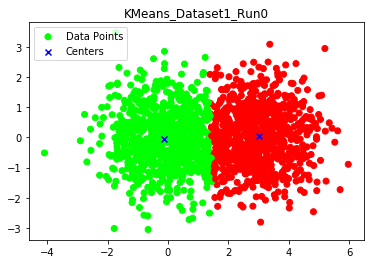

In [6]:
r = 5
loss_array = []
preds_array = []
centers_array = []

for i in range(5):
    print("Run number",i+1)
    preds, centers, losses = kmeans(data, K)
    loss_array.append(losses[-1])
    preds_array.append(preds)
    centers_array.append(centers)
    draw_loss_graph(losses, "KMeans_Dataset1_Run"+str(i)+"_SSE.png")
    
ix = np.argmin(loss_array)
print("Lowest SSE during Run",ix,"SSE=",loss_array[ix])
display_clusters(data, centers_array[ix], preds_array[ix], "KMeans_Dataset1_Run"+str(ix))

### Random Init GMM

Initial Avg. LogLoss: 7.187110725302378
Iteration 1 Avg. LogLoss: 3.4291631484537515
Iteration 2 Avg. LogLoss: 3.4202566504292884
Iteration 3 Avg. LogLoss: 3.416660003270911
Iteration 4 Avg. LogLoss: 3.414826958453743
Iteration 5 Avg. LogLoss: 3.4137600595481286
Iteration 6 Avg. LogLoss: 3.413082877529364
Iteration 7 Avg. LogLoss: 3.4126259153951737
Iteration 8 Avg. LogLoss: 3.4123031544734896
Iteration 9 Avg. LogLoss: 3.412066972788431
Iteration 10 Avg. LogLoss: 3.411889196553862
Iteration 11 Avg. LogLoss: 3.411752260930438
Iteration 12 Avg. LogLoss: 3.411644739840156
Iteration 13 Avg. LogLoss: 3.4115589344175588
Iteration 14 Avg. LogLoss: 3.4114895012618502
Iteration 15 Avg. LogLoss: 3.411432636819535
Iteration 16 Avg. LogLoss: 3.4113855738459558
Iteration 17 Avg. LogLoss: 3.411346260310878
Iteration 18 Avg. LogLoss: 3.411313148798196
Iteration 19 Avg. LogLoss: 3.41128505491914
Iteration 20 Avg. LogLoss: 3.41126106001647
Iteration 21 Avg. LogLoss: 3.4112404429863545
Iteration 22 Avg.

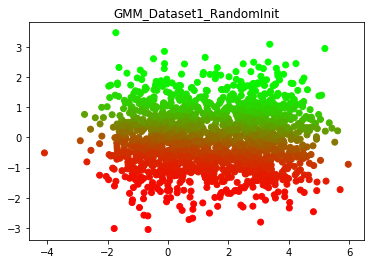

In [7]:
#160,566,754,630
# i = int(random.random()*1000)
# print(i)
# np.random.seed(i)

mus, sigmas, pis = random_init_gmm(data, K)
pdfs = get_pdfs(mus, sigmas)
piN = get_piN(data, pdfs, pis, K)
prev = loglikelihood(piN)
print("Initial Avg. LogLoss:",str(prev))
log_losses = [prev]

i=0
while True:
    resp = get_resp(piN)
    mus, sigmas, pis = m_step(data, resp)
    pdfs = get_pdfs(mus, sigmas)
    piN = get_piN(data, pdfs, pis, K)
    x = loglikelihood(piN)
    print("Iteration "+str(i+1)+" Avg. LogLoss: "+str(x))
    log_losses.append(x)
    if abs(prev-x)<10**-5:
        break
    prev = x
    i+=1
    
    
resp = get_resp(piN)
draw_logloss_graph(log_losses, "GMM_Dataset1_RandomInit_LogLoss.png")
display_gmm(data, resp, K, "GMM_Dataset1_RandomInit")

### GMM Initialized with KMeans result

Initial Avg. LogLoss: 4.061275116268424
Iteration 1 Avg. LogLoss: 3.3516282357690845
Iteration 2 Avg. LogLoss: 3.348710835603262
Iteration 3 Avg. LogLoss: 3.3474512440857245
Iteration 4 Avg. LogLoss: 3.346534380951957
Iteration 5 Avg. LogLoss: 3.345744884307671
Iteration 6 Avg. LogLoss: 3.3450397429416863
Iteration 7 Avg. LogLoss: 3.3444084154892346
Iteration 8 Avg. LogLoss: 3.3438461720317743
Iteration 9 Avg. LogLoss: 3.3433487862426956
Iteration 10 Avg. LogLoss: 3.342911645114116
Iteration 11 Avg. LogLoss: 3.3425297727605674
Iteration 12 Avg. LogLoss: 3.3421980146006693
Iteration 13 Avg. LogLoss: 3.341911219989241
Iteration 14 Avg. LogLoss: 3.341664390315506
Iteration 15 Avg. LogLoss: 3.3414527883228855
Iteration 16 Avg. LogLoss: 3.341272011570615
Iteration 17 Avg. LogLoss: 3.3411180351991185
Iteration 18 Avg. LogLoss: 3.34098722988504
Iteration 19 Avg. LogLoss: 3.340876360834721
Iteration 20 Avg. LogLoss: 3.340782573155442
Iteration 21 Avg. LogLoss: 3.340703368168804
Iteration 22 Av

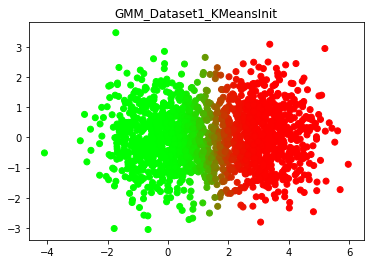

In [8]:
mus, sigmas, pis = init_gmm(data, centers, preds)
pdfs = get_pdfs(mus, sigmas)
piN = get_piN(data, pdfs, pis, K)
prev = loglikelihood(piN)
print("Initial Avg. LogLoss:",str(prev))
log_losses = [prev]

i=0
while True:
    resp = get_resp(piN)
    mus, sigmas, pis = m_step(data, resp)
    pdfs = get_pdfs(mus, sigmas)
    piN = get_piN(data, pdfs, pis, K)
    x = loglikelihood(piN)
    log_losses.append(x)
    print("Iteration "+str(i+1)+" Avg. LogLoss: "+str(x))
    if abs(prev-x)<10**-5:
        break
    prev = x
    i+=1

resp = get_resp(piN)
draw_logloss_graph(log_losses, "GMM_Dataset1_KMeansInit_LogLoss.png")
display_gmm(data, resp, K, "GMM_Dataset1_KMeansInit")

# Running for Dataset_2.txt

In [9]:
data = read_file("Dataset_2.txt")
K = 3

### Kmeans

Run number 1
Initial Loss: 3.618902193709115
Iteration: 1 Loss: 1.2111689751422743
Iteration: 2 Loss: 1.189791878021058
Iteration: 3 Loss: 1.1825926723056033
Iteration: 4 Loss: 1.1801252745281854
Iteration: 5 Loss: 1.1792677952196615
Iteration: 6 Loss: 1.179160634998263
Iteration: 7 Loss: 1.1790654187907483
Iteration: 8 Loss: 1.1789786900661228
Iteration: 9 Loss: 1.1788850610262671
Iteration: 10 Loss: 1.1787897491183719
Iteration: 11 Loss: 1.1787829727146233
Iteration: 12 Loss: 1.1787796700494175
Iteration: 13 Loss: 1.1787796700494175

Run number 2
Initial Loss: 6.729936805183231
Iteration: 1 Loss: 1.414600347242567
Iteration: 2 Loss: 1.3363520789888232
Iteration: 3 Loss: 1.2999186454180442
Iteration: 4 Loss: 1.2765269713835097
Iteration: 5 Loss: 1.2502411763562156
Iteration: 6 Loss: 1.2346388144880112
Iteration: 7 Loss: 1.2324363794208912
Iteration: 8 Loss: 1.2319563067996022
Iteration: 9 Loss: 1.2315060321555726
Iteration: 10 Loss: 1.2311555644061434
Iteration: 11 Loss: 1.23112293469

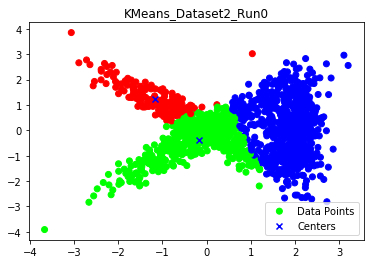

In [10]:
r = 5
loss_array = []
preds_array = []
centers_array = []

for i in range(5):
    print("Run number",i+1)
    preds, centers, losses = kmeans(data, K)
    loss_array.append(losses[-1])
    preds_array.append(preds)
    centers_array.append(centers)
    draw_loss_graph(losses, "KMeans_Dataset2_Run"+str(i)+"_SSE.png")
    
ix = np.argmin(loss_array)
print("Lowest SSE during Run",ix,"SSE=",loss_array[ix])
display_clusters(data, centers_array[ix], preds_array[ix], "KMeans_Dataset2_Run"+str(ix))

### Random init GMM

Initial Avg. LogLoss: 4.409439842764965
Iteration 1 Avg. LogLoss: 3.058552052987086
Iteration 2 Avg. LogLoss: 3.03172282928285
Iteration 3 Avg. LogLoss: 3.0148280213297864
Iteration 4 Avg. LogLoss: 3.0042431709774724
Iteration 5 Avg. LogLoss: 2.995894587745824
Iteration 6 Avg. LogLoss: 2.988660766438035
Iteration 7 Avg. LogLoss: 2.9825122014990373
Iteration 8 Avg. LogLoss: 2.9773886353636785
Iteration 9 Avg. LogLoss: 2.97320222567744
Iteration 10 Avg. LogLoss: 2.9699822540431877
Iteration 11 Avg. LogLoss: 2.967584958309586
Iteration 12 Avg. LogLoss: 2.9657066996809176
Iteration 13 Avg. LogLoss: 2.963993509326186
Iteration 14 Avg. LogLoss: 2.961999416058094
Iteration 15 Avg. LogLoss: 2.9591301348659873
Iteration 16 Avg. LogLoss: 2.954931560457181
Iteration 17 Avg. LogLoss: 2.9499528747329786
Iteration 18 Avg. LogLoss: 2.945560676972018
Iteration 19 Avg. LogLoss: 2.942334705102592
Iteration 20 Avg. LogLoss: 2.940028617796863
Iteration 21 Avg. LogLoss: 2.938307987789867
Iteration 22 Avg. 

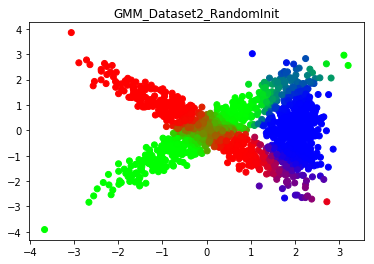

In [11]:
#160,566,754,630
# i = int(random.random()*1000)
# print(i)
# np.random.seed(i)

mus, sigmas, pis = random_init_gmm(data, K)
pdfs = get_pdfs(mus, sigmas)
piN = get_piN(data, pdfs, pis, K)
prev = loglikelihood(piN)
log_losses = [prev]
print("Initial Avg. LogLoss:",str(prev))

i=0
while True:
    resp = get_resp(piN)
    mus, sigmas, pis = m_step(data, resp)
    pdfs = get_pdfs(mus, sigmas)
    piN = get_piN(data, pdfs, pis, K)
    x = loglikelihood(piN)
    log_losses.append(x)
    print("Iteration "+str(i+1)+" Avg. LogLoss: "+str(x))
    if abs(prev-x)<10**-5:
        break
    prev = x
    i+=1
    

draw_logloss_graph(log_losses, "GMM_Dataset2_RandomInit_LogLoss.png")
resp = get_resp(piN)
display_gmm(data, resp, K, "GMM_Dataset2_RandomInit")

### GMM Initialized with KMeans result

Initial Avg. LogLoss: 2.808614514774401
Iteration 1 Avg. LogLoss: 2.7530646099295093
Iteration 2 Avg. LogLoss: 2.727272835266537
Iteration 3 Avg. LogLoss: 2.7010820423833874
Iteration 4 Avg. LogLoss: 2.673972136912981
Iteration 5 Avg. LogLoss: 2.652145288417356
Iteration 6 Avg. LogLoss: 2.6379515472594166
Iteration 7 Avg. LogLoss: 2.6294274496147554
Iteration 8 Avg. LogLoss: 2.6243423382037343
Iteration 9 Avg. LogLoss: 2.6214513130049344
Iteration 10 Avg. LogLoss: 2.619899199223263
Iteration 11 Avg. LogLoss: 2.619089032293355
Iteration 12 Avg. LogLoss: 2.618672240934252
Iteration 13 Avg. LogLoss: 2.61845979671706
Iteration 14 Avg. LogLoss: 2.6183521753838317
Iteration 15 Avg. LogLoss: 2.6182978739039613
Iteration 16 Avg. LogLoss: 2.618270544928538
Iteration 17 Avg. LogLoss: 2.618256812289526
Iteration 18 Avg. LogLoss: 2.6182499182644916


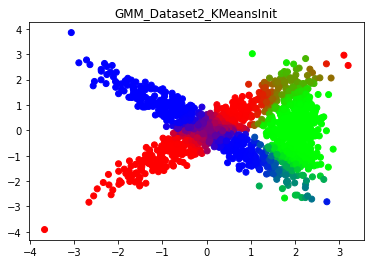

In [12]:
mus, sigmas, pis = init_gmm(data, centers, preds)
pdfs = get_pdfs(mus, sigmas)
piN = get_piN(data, pdfs, pis, K)
prev = loglikelihood(piN)
print("Initial Avg. LogLoss:",str(prev))
log_losses = [prev]

i=0
while True:
    resp = get_resp(piN)
    mus, sigmas, pis = m_step(data, resp)
    pdfs = get_pdfs(mus, sigmas)
    piN = get_piN(data, pdfs, pis, K)
    x = loglikelihood(piN)
    log_losses.append(x)
    print("Iteration "+str(i+1)+" Avg. LogLoss: "+str(x))
    if abs(prev-x)<10**-5:
        break
    prev = x
    i+=1
    
draw_logloss_graph(log_losses, "GMM_Dataset2_KMeansInit_LogLoss.png")
resp = get_resp(piN)
display_gmm(data, resp, K, "GMM_Dataset2_KMeansInit")